<a href="https://colab.research.google.com/github/janzaw04/myTestRep/blob/main/%C4%87wiczenia6domowa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
'''Trains a simple deep NN on the MNIST dataset.

Gets to 99.6% test accuracy after 40 epochs
(there is *a lot* of margin for parameter tuning).
2 seconds per epoch on a K520 GPU.
'''

from __future__ import print_function

import matplotlib.pyplot as plt
import numpy as np

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.optimizers import RMSprop, Adam, Adadelta

from keras.utils.vis_utils import plot_model
from IPython.display import Image 
from keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import EarlyStopping

# install optuna
! pip install optuna

import optuna


batch_size = 128
num_classes = 10
epochs = 50

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train0), (x_test, y_test0) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)



x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train0, num_classes)
y_test = keras.utils.to_categorical(y_test0, num_classes)

     |████████████████████████████████| 286kB 19.5MB/s 
     |████████████████████████████████| 163kB 57.8MB/s 
     |████████████████████████████████| 81kB 12.0MB/s 
     |████████████████████████████████| 481kB 61.3MB/s 
     |████████████████████████████████| 112kB 61.0MB/s 
     |████████████████████████████████| 133kB 24.9MB/s 
     |████████████████████████████████| 51kB 10.0MB/s 
  Created wheel for Mako: filename=Mako-1.1.4-py2.py3-none-any.whl size=75675 sha256=ff20396e3970c807f68a5545018221971d7404031b5bd550c666e33a8b25b1e3
  Stored in directory: /root/.cache/pip/wheels/ad/10/d3/aeb26e20d19045e2a68e5d3cbb57432e11b5d9c92c99f98d47
  Created wheel for PrettyTable: filename=prettytable-0.7.2-cp36-none-any.whl size=13702 sha256=b82aa7989df491e9a364bc6c4a2b5a5c7c7231b23daced3944c84f68a8ac8a78
  Stored in directory: /root/.cache/pip/wheels/80/34/1c/3967380d9676d162cb59513bd9dc862d0584e045a162095606
  Created wheel for pyperclip: filename=pyperclip-1.8.1-cp36-none-any.whl size=11120 

In [2]:
N_TRAIN_EXAMPLES = 1000 #3000
N_TEST_EXAMPLES = 10000
x_train = x_train[:N_TRAIN_EXAMPLES]
x_test = x_test[:N_TEST_EXAMPLES]
y_train = y_train[:N_TRAIN_EXAMPLES]
y_test = y_test[:N_TEST_EXAMPLES]

In [3]:
def c_model():
  # Our old fully connected (dense) network
  #model = Sequential()
  #model.add(Dense(512, activation='relu', input_shape=(784,)))
  #model.add(Dropout(0.2))
  #model.add(Dense(512, activation='relu'))
  #model.add(Dropout(0.2))
  #model.add(Dense(512, activation='relu'))
  #model.add(Dropout(0.2))
  #model.add(Dense(num_classes, activation='softmax'))
  model = Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  model.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation='softmax'))

  return model

In [4]:
def objective(trial):
  
  rotation_range=trial.suggest_uniform('rotation_range', .00,30)
  zoom_range=trial.suggest_uniform('zoom_range', .00,0.30)
  shift_range=trial.suggest_uniform('shift_range', .00,0.20)
  
  datagen = ImageDataGenerator( 
    rotation_range=rotation_range,
    width_shift_range=shift_range,
    height_shift_range=shift_range,
    zoom_range=zoom_range
    )

  model = c_model()

  from keras.callbacks import EarlyStopping

  model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])
  
  e_s=EarlyStopping(monitor='val_accuracy', patience=12, verbose=1)

  history = model.fit(datagen.flow(x_train, y_train,
                    batch_size=batch_size),
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=0,
                    validation_data=(x_test, y_test), 
                    callbacks=[e_s])

  score = model.evaluate(x_test, y_test,verbose=0)

  return score[1]

In [5]:
study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(), sampler=optuna.samplers.TPESampler() )
study.optimize(objective, n_trials=30, timeout=1200)

[I 2021-01-25 20:34:37,264] A new study created in memory with name: no-name-9b0a88e2-93da-49d6-a555-a1a5b979c154
[I 2021-01-25 20:35:17,247] Trial 0 finished with value: 0.9688000082969666 and parameters: {'rotation_range': 25.55742586358462, 'zoom_range': 0.1390867044042308, 'shift_range': 0.11826684698832697}. Best is trial 0 with value: 0.9688000082969666.
[I 2021-01-25 20:35:44,045] Trial 1 finished with value: 0.9721999764442444 and parameters: {'rotation_range': 22.21584707362179, 'zoom_range': 0.055961724567276085, 'shift_range': 0.12040446994265447}. Best is trial 1 with value: 0.9721999764442444.
[I 2021-01-25 20:36:10,998] Trial 2 finished with value: 0.9789999723434448 and parameters: {'rotation_range': 15.251194216534067, 'zoom_range': 0.2086210366544133, 'shift_range': 0.0942693316541335}. Best is trial 2 with value: 0.9789999723434448.


Epoch 00048: early stopping


[I 2021-01-25 20:36:36,507] Trial 3 finished with value: 0.9696999788284302 and parameters: {'rotation_range': 20.374961559396944, 'zoom_range': 0.1266041683317977, 'shift_range': 0.025999803553761015}. Best is trial 2 with value: 0.9789999723434448.
[I 2021-01-25 20:37:03,064] Trial 4 finished with value: 0.9616000056266785 and parameters: {'rotation_range': 6.984492770157326, 'zoom_range': 0.2403967894703238, 'shift_range': 0.19564485214799512}. Best is trial 2 with value: 0.9789999723434448.
[I 2021-01-25 20:37:29,847] Trial 5 finished with value: 0.9656000137329102 and parameters: {'rotation_range': 18.98356795549296, 'zoom_range': 0.2121970089681807, 'shift_range': 0.1786386725293223}. Best is trial 2 with value: 0.9789999723434448.
[I 2021-01-25 20:37:56,606] Trial 6 finished with value: 0.9692999720573425 and parameters: {'rotation_range': 4.775330562484522, 'zoom_range': 0.05266488603529505, 'shift_range': 0.10308197805614204}. Best is trial 2 with value: 0.9789999723434448.
[I

Epoch 00050: early stopping


[I 2021-01-25 20:41:56,706] Trial 15 finished with value: 0.9747999906539917 and parameters: {'rotation_range': 16.364429535404525, 'zoom_range': 0.1118847049274824, 'shift_range': 0.08935897035056946}. Best is trial 2 with value: 0.9789999723434448.
[I 2021-01-25 20:42:23,401] Trial 16 finished with value: 0.967199981212616 and parameters: {'rotation_range': 0.2576531259390755, 'zoom_range': 0.17095880047218717, 'shift_range': 0.1555696859727476}. Best is trial 2 with value: 0.9789999723434448.
[I 2021-01-25 20:42:50,118] Trial 17 finished with value: 0.9761999845504761 and parameters: {'rotation_range': 16.52249357538862, 'zoom_range': 0.26707683157456036, 'shift_range': 0.08789287241947867}. Best is trial 2 with value: 0.9789999723434448.
[I 2021-01-25 20:43:16,826] Trial 18 finished with value: 0.9690999984741211 and parameters: {'rotation_range': 9.951911890406759, 'zoom_range': 0.0063922258825091505, 'shift_range': 0.1310379720253974}. Best is trial 2 with value: 0.97899997234344

Epoch 00048: early stopping


[I 2021-01-25 20:46:49,024] Trial 26 finished with value: 0.972599983215332 and parameters: {'rotation_range': 18.108402816900583, 'zoom_range': 0.19848209220394483, 'shift_range': 0.1108609542167886}. Best is trial 2 with value: 0.9789999723434448.
[I 2021-01-25 20:47:15,725] Trial 27 finished with value: 0.9767000079154968 and parameters: {'rotation_range': 10.560985380843, 'zoom_range': 0.24764338847616837, 'shift_range': 0.0867346729441397}. Best is trial 2 with value: 0.9789999723434448.
[I 2021-01-25 20:47:42,306] Trial 28 finished with value: 0.9684000015258789 and parameters: {'rotation_range': 21.776461997132976, 'zoom_range': 0.14784460413753922, 'shift_range': 0.1330314917310534}. Best is trial 2 with value: 0.9789999723434448.
[I 2021-01-25 20:48:08,940] Trial 29 finished with value: 0.9753999710083008 and parameters: {'rotation_range': 14.568863559039713, 'zoom_range': 0.12923246474598055, 'shift_range': 0.04540732253421558}. Best is trial 2 with value: 0.9789999723434448.

In [6]:
print("Number trials: {}".format(len(study.trials)))
print("Best trial:")
trial=study.best_trial
print("Value: {}".format(trial.value))
print("Params")
for key, value in trial.params.items():
  print("  {}:{}  ".format(key, value))

Number trials: 30
Best trial:
Value: 0.9789999723434448
Params
  rotation_range:15.251194216534067  
  zoom_range:0.2086210366544133  
  shift_range:0.0942693316541335  


In [7]:
rotation_range=trial.params.get('rotation_range')
zoom_range=trial.params.get('zoom_range')
shift_range=trial.params.get('shift_range')

  
datagen = ImageDataGenerator( 
    rotation_range=rotation_range,
    width_shift_range=shift_range,
    height_shift_range=shift_range,
    zoom_range=zoom_range
    )

model = c_model()

from keras.callbacks import EarlyStopping

model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

e_s=EarlyStopping(monitor='val_accuracy',patience=12,verbose=1)

history = model.fit(datagen.flow(x_train, y_train,
                    batch_size=batch_size),
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=1,
                    validation_data=(x_test, y_test),
                    callbacks=[e_s])

Epoch 1/50
8/8 [==============================] - 1s 116ms/step - loss: 2.2989 - accuracy: 0.1267 - val_loss: 2.1744 - val_accuracy: 0.5351
Epoch 2/50
8/8 [==============================] - 1s 72ms/step - loss: 2.1754 - accuracy: 0.2492 - val_loss: 1.5446 - val_accuracy: 0.5683
Epoch 3/50
8/8 [==============================] - 1s 70ms/step - loss: 1.9586 - accuracy: 0.3532 - val_loss: 1.0331 - val_accuracy: 0.7489
Epoch 4/50
8/8 [==============================] - 1s 75ms/step - loss: 1.5419 - accuracy: 0.4754 - val_loss: 0.7151 - val_accuracy: 0.7925
Epoch 5/50
8/8 [==============================] - 1s 72ms/step - loss: 1.3882 - accuracy: 0.5151 - val_loss: 0.5801 - val_accuracy: 0.8601
Epoch 6/50
8/8 [==============================] - 1s 75ms/step - loss: 1.2044 - accuracy: 0.6041 - val_loss: 0.4115 - val_accuracy: 0.8846
Epoch 7/50
8/8 [==============================] - 1s 71ms/step - loss: 0.9706 - accuracy: 0.6617 - val_loss: 0.3505 - val_accuracy: 0.9030
Epoch 8/50
8/8 [==========

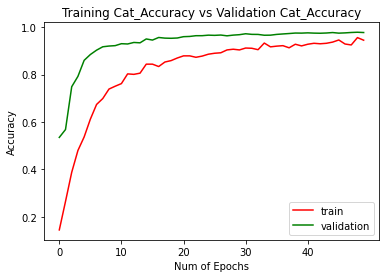

In [8]:
# Plots for training and testing process: loss and accuracy

n_epochs = len(history.history['loss'])

plt.figure(0)
plt.plot(history.history['accuracy'],'r')
plt.plot(history.history['val_accuracy'],'g')
plt.xticks(np.arange(0, n_epochs, 10.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Cat_Accuracy vs Validation Cat_Accuracy")
plt.legend(['train','validation'])

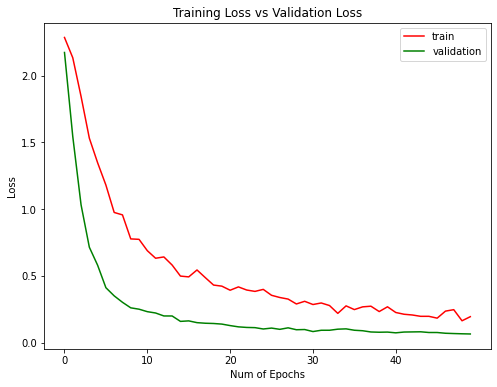

In [9]:
plt.figure(1)
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'g')
plt.xticks(np.arange(0, n_epochs, 10.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])
plt.show()

(1000, 28, 28)


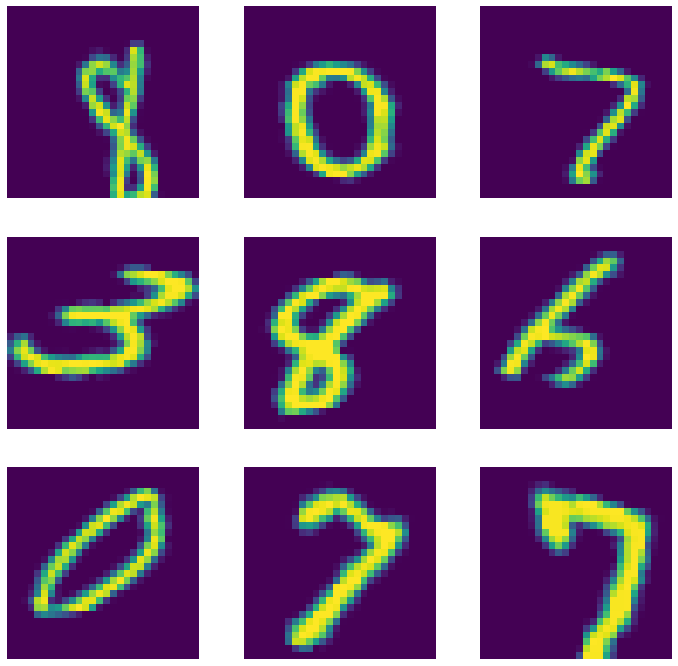

In [10]:
print(x_train.reshape((len(x_train),img_rows, img_cols)).shape)
# see example augmentation images
fig = plt.figure(figsize=(12, 12))
for X_batch, y_batch in datagen.flow(x_train, y_train, batch_size=9):
    for i in range(0, 9):
         plt.subplot(330 + 1 + i)
         plt.imshow(X_batch[i].reshape((img_rows, img_cols)))
         plt.axis('off')
    plt.show()
    break

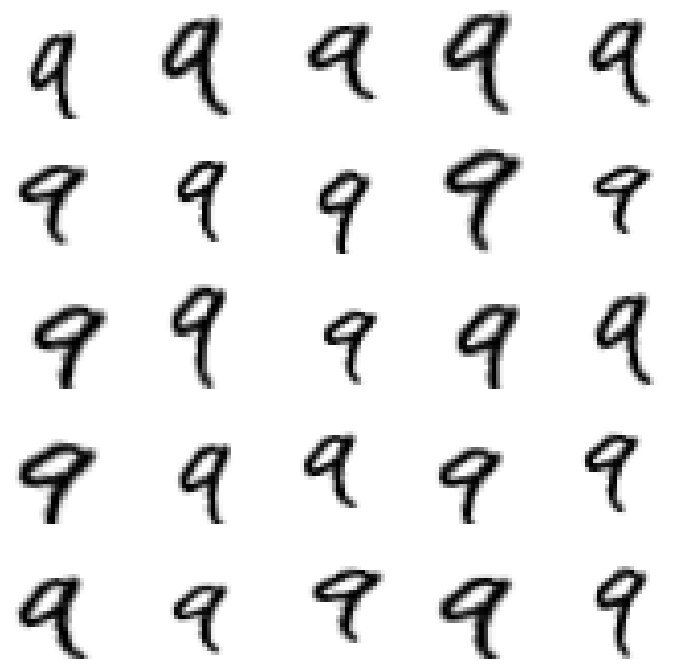

In [11]:
# see example augmentation images
fig = plt.figure(figsize=(12, 12))

for i in range(0, 25):
    for X_batch, y_batch in datagen.flow(x_train[4:6], y_train[4:6], batch_size=1, shuffle=False):
         plt.subplot(5,5,i+1)
         plt.imshow(X_batch[0].reshape((img_rows, img_cols)), cmap=plt.cm.binary, interpolation='nearest')
         plt.axis('off')
         break

plt.show()

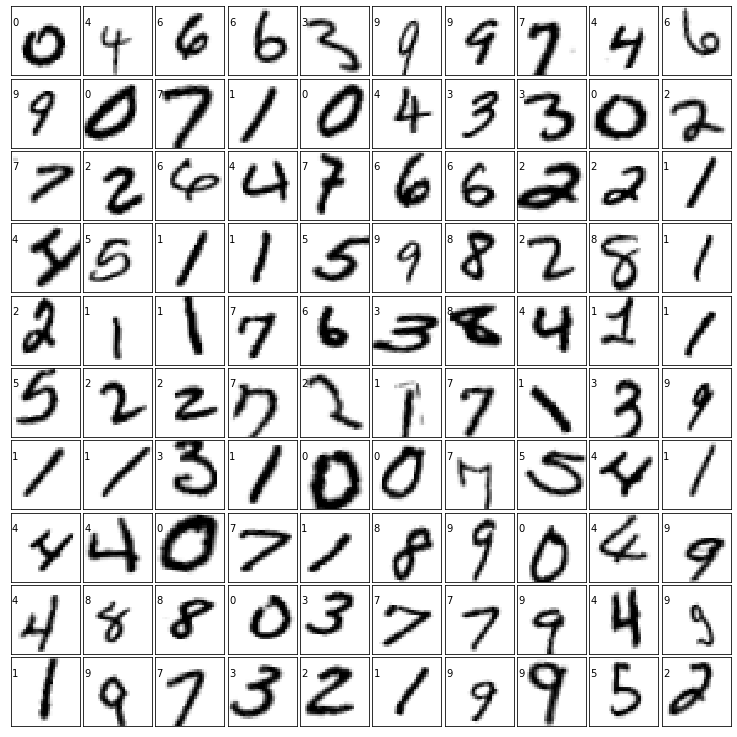

In [12]:
#visualize the digits
fig = plt.figure(figsize=(10, 10)) # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
# generate augmented plot
X_train, Y_train = datagen.flow(x_train,y_train, batch_size=100).next()
for i in range(100):
  ax = fig.add_subplot(10, 10, i + 1, xticks=[], yticks=[])
  ax.imshow(X_train[i].reshape(img_rows, img_cols), cmap=plt.cm.binary, interpolation='nearest')
  # label the image with the target value
  ax.text(0, 7, str(np.argmax(Y_train[i])))

In [13]:
# evaluate loaded model
scores_train = model.evaluate(x_train, y_train, verbose=0)
scores_test  = model.evaluate(x_test,  y_test,  verbose=0)

print("Accuracy Train: %.2f%% , Test: %.2f%% " % (scores_train[1]*100, scores_test[1]*100 ))

Accuracy Train: 99.20% , Test: 97.74% 


In [14]:
# Confusion matrix result

from sklearn.metrics import classification_report, confusion_matrix
Y_pred = model.predict(x_test, verbose=2)

y_pred = np.argmax(Y_pred, axis=1)

y_test2 = np.argmax(y_test, axis=1)



#confusion matrix
cm = confusion_matrix(np.argmax(y_test,axis=1),y_pred)
print(cm)

313/313 - 0s
[[ 973    0    2    0    1    0    1    2    0    1]
 [   0 1116    2    1    0    3    1    7    5    0]
 [   1    0 1018    5    0    0    0    6    2    0]
 [   0    0    1  996    0    3    0    5    4    1]
 [   2    1    1    0  951    0    2    0    0   25]
 [   0    2    0    8    0  874    2    1    3    2]
 [   7    4    0    0    3    2  940    0    2    0]
 [   1    2   13    1    2    0    0 1000    0    9]
 [  21    1    5    2    7    3    2    0  923   10]
 [   2    2    0    4    7    2    1    7    1  983]]


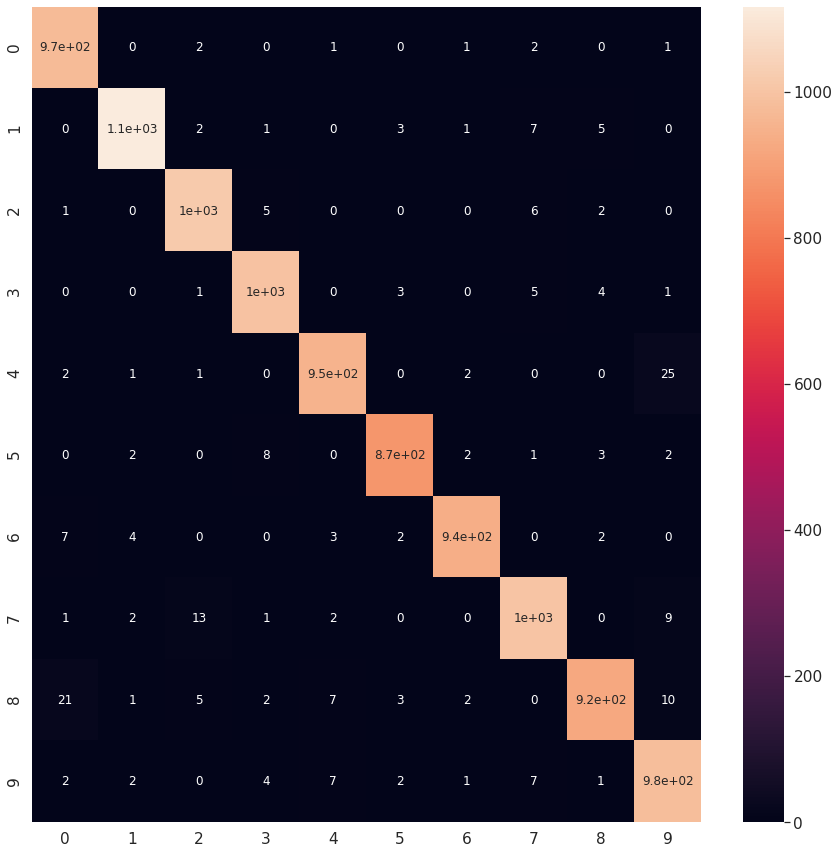

In [15]:
# Visualizing of confusion matrix
import seaborn as sn
import pandas  as pd


df_cm = pd.DataFrame(cm, range(10),range(10))
#                     range(num_classes),
#                  range(num_classes))
#plt.figure(figsize = (10,7))
plt.figure(2,figsize = (15,15) )
sn.set(font_scale=1.4) #for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 12})# font size
plt.show()

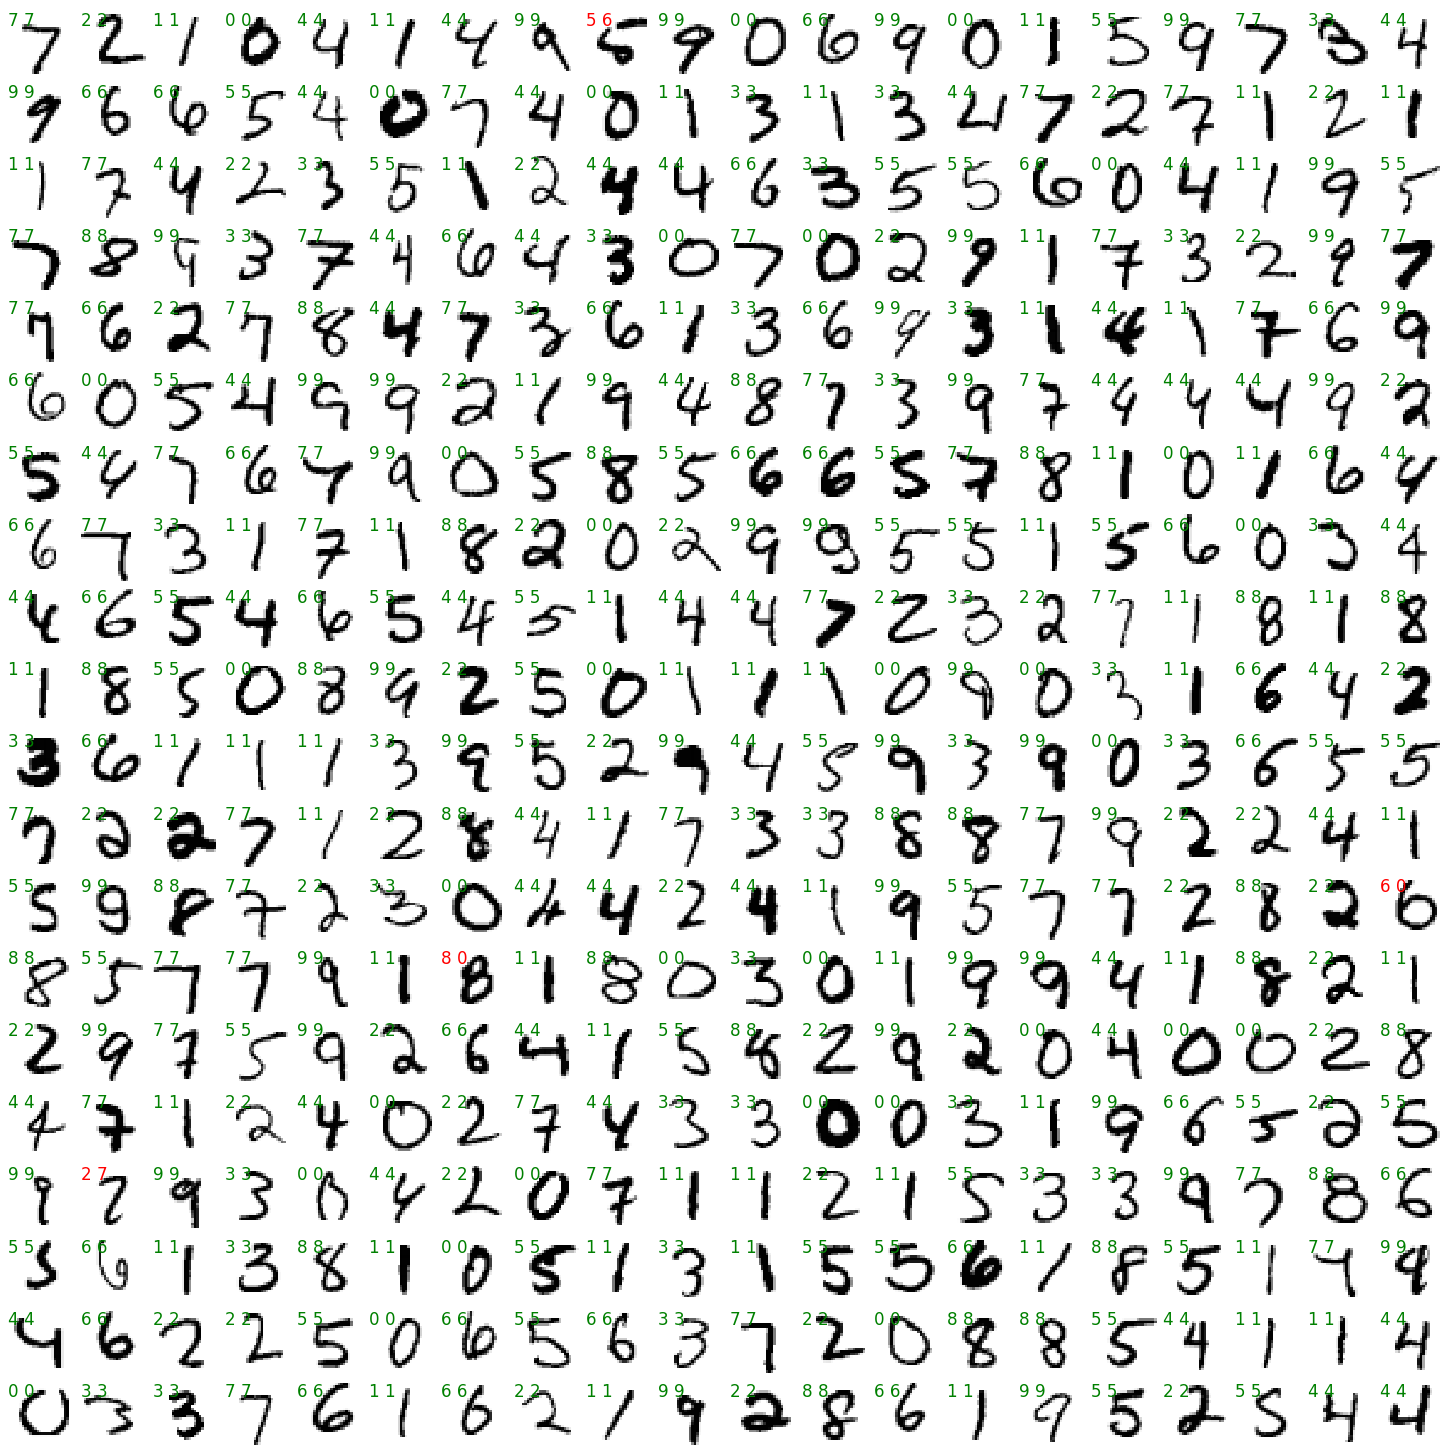

In [16]:
# use the model to predict the labels of the test data
predicted = model.predict(x_test)
expected = y_test0



# Plot the prediction
fig = plt.figure(figsize=(20, 20))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)


# plot the digits: each image is 28x28 pixels
for i in range(400):
    ax = fig.add_subplot(20, 20, i + 1, xticks=[], yticks=[])
    ax.imshow(x_test[i].reshape(img_rows, img_cols), cmap=plt.cm.binary, interpolation='nearest')

    # label the image with the target value
    if np.argmax(predicted[i]) == expected[i]:
        ax.text(0, 7, str(expected[i])+" "+str(np.argmax(predicted[i])), color='green')
    else:
        ax.text(0, 7, str(expected[i])+" "+str(np.argmax(predicted[i])), color='red')

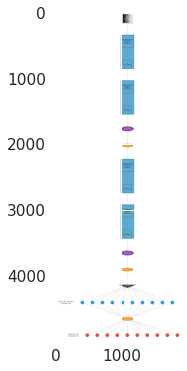

In [17]:
# Creates the graph.png file

! pip3 install keras-visualizer
from keras_visualizer import visualizer  

#create the graph.png image
visualizer(model=model, view=True, format='png', filename='graph')

#show the graph
import matplotlib.image as mpimg
img = mpimg.imread('graph.png')
imgplot = plt.imshow(img,)
plt.show()